<a href="https://colab.research.google.com/github/JuanJGalindo/ML-Theory/blob/main/MaterialScience/ensayoTraccion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Laboratorio: Ensayo de Tracción en Materiales**

Este cuadernillo en Google Colab desarrolla los conceptos fundamentales relacionados con el ensayo de tracción, tomando como base los datos constatados en la guía de Monitoría 2.


##**1. Contexto y geometría de la muestra**

La muestra es una varilla cilíndrica con:

- Longitud inicial $L_0 = 3.937'' = 0.1000$ m
- Diámetro inicial $d_0 = 1.088'' = 0.02764$ m
- Área inicial de sección transversal: $A_0 = \pi (d_0/2)^2$

La tabla de datos entregada relaciona **Carga (kN)** y **Alargamiento (cm)**.


In [34]:
import pandas as pd
import numpy as np

# Datos de carga (kN) y alargamiento (cm)
data = {
    'Carga_kN': [0, 180, 360, 540, 660, 720, 690, 630, 540],
    'Alargamiento_cm': [0, 0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24]
}
df = pd.DataFrame(data)

# Conversiones
df['Carga_N'] = df['Carga_kN']*1000
df['Alargamiento_m'] = df['Alargamiento_cm']/100

df

,Carga_kN,Alargamiento_cm,Carga_N,Alargamiento_m
0,0,0.00,0,0.0000
1,180,0.03,180000,0.0003
2,360,0.06,360000,0.0006
3,540,0.09,540000,0.0009
4,660,0.12,660000,0.0012
5,720,0.15,720000,0.0015
6,690,0.18,690000,0.0018
7,630,0.21,630000,0.0021
8,540,0.24,540000,0.0024


##**2. Esfuerzo y deformación convencional**

Se calculan como:

- $\sigma = F/A_0$
- $\epsilon = \Delta L/L_0$

Esto permite graficar la curva esfuerzo-deformación convencional.

In [35]:
import math

# Geometría inicial
L0 = 0.1000 # m
d0 = 0.02764 # m
A0 = math.pi*(d0/2)**2

df['Esfuerzo_Pa'] = df['Carga_N']/A0
df['Deformacion'] = df['Alargamiento_m']/L0

df[['Carga_kN','Esfuerzo_Pa','Deformacion']]

,Carga_kN,Esfuerzo_Pa,Deformacion
0,0,0.000000e+00,0.000
1,180,2.999898e+08,0.003
2,360,5.999797e+08,0.006
3,540,8.999695e+08,0.009
4,660,1.099963e+09,0.012
5,720,1.199959e+09,0.015
6,690,1.149961e+09,0.018
7,630,1.049964e+09,0.021
8,540,8.999695e+08,0.024


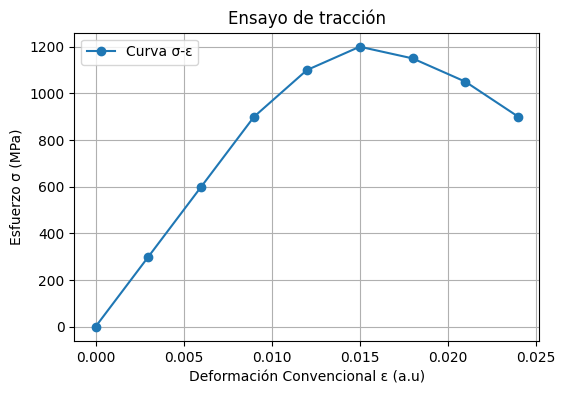

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(df['Deformacion'], df['Esfuerzo_Pa']/1e6, 'o-', label='Curva σ-ε')
plt.xlabel('Deformación Convencional ε (a.u)')
plt.ylabel('Esfuerzo σ (MPa)')
plt.title('Ensayo de tracción')
plt.legend()
plt.grid(True)
plt.show()

##**a) Módulo de elasticidad**

Se estima de la pendiente de la parte lineal inicial de la curva esfuerzo-deformación.

In [37]:
# Tomamos los primeros tres puntos para la zona lineal
coeffs = np.polyfit(df['Deformacion'].iloc[0:3], df['Esfuerzo_Pa'].iloc[0:3], 1)
E = coeffs[0] # Pa

print(f"Módulo Elástico (Young): {E/1e9} GPa")

Módulo Elástico (Young): 99.99661332611895 GPa


###**b) Límite elástico al 0.2%**

Se determina con el método de la **offset line** (0.002 de deformación).

In [52]:
from scipy.interpolate import CubicSpline
from scipy.optimize import fsolve

# Recta desplazada 0.2%
offset = 0.002
slope = E
intercept = -slope*offset

# Datos Experimentales
stressVals = df['Esfuerzo_Pa'].values
strainVals = df['Deformacion'].values

# Función de Interpolación de Datos Experimentales - Cubic Spline
interpStressStrain = CubicSpline(strainVals, stressVals)

# Generación de Puntos de Gráfica de Interpolación - Intercepto
interpPoints = np.linspace(strainVals.min(), strainVals.max(), 500)
diffArray = interpStressStrain(interpPoints) - (slope * interpPoints + intercept)

# Función para Hallar Intercepto
def interceptFinding(strain):
    return interpStressStrain(strain) - (slope * strain + intercept)

# Con un estimado inicial y fsolve encontramos la intercepción entre rectas
initialGuessIndex = np.argmin(abs(stressVals - (slope * strainVals + intercept)))
initialGuessStrain = strainVals[initialGuessIndex]

# Hallando interceptos
intersectStrain = fsolve(interceptFinding, initialGuessStrain)[0]
intersectStress = slope * intersectStrain + intercept

sigmaY = intersectStress
yieldStrain = intersectStrain

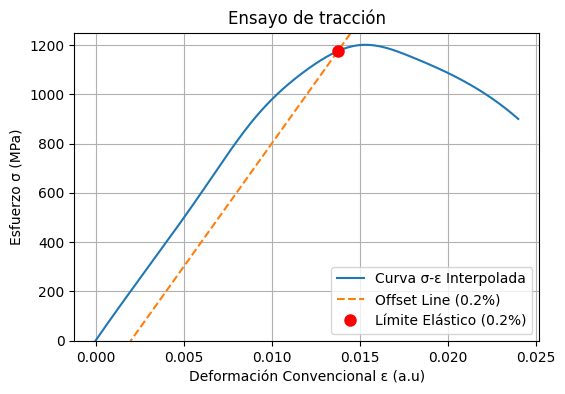

Límite elástico al 0.2%: 1175.2162399415536 MPa


In [53]:
plt.figure(figsize=(6,4))
# Curva de Interpolación
plt.plot(interpPoints, interpStressStrain(interpPoints)/1e6, '-', label='Curva σ-ε Interpolada')
# Curva Offset
plt.plot(interpPoints, (slope * interpPoints + intercept)/1e6, '--', label='Offset Line (0.2%)')
plt.plot(yieldStrain, sigmaY/1e6, 'ro', markersize=8, label='Límite Elástico (0.2%)')

plt.xlabel('Deformación Convencional ε (a.u)')
plt.ylabel('Esfuerzo σ (MPa)')
plt.ylim(-0.002, 1250)
plt.title('Ensayo de tracción')
plt.legend()
plt.grid(True)
plt.show()

print(f"Límite elástico al 0.2%: {sigmaY/1e6} MPa")

###**c) Resistencia a la tracción (UTS)**

Es el máximo esfuerzo alcanzado en la curva esfuerzo-deformación.

In [40]:
UTS = df['Esfuerzo_Pa'].max()
print(f"Resistencia a la Tracción: {UTS/1e6} MPa")

Resistencia a la Tracción: 1199.959359913427 MPa


###**d) Porcentaje de alargamiento**

%Alargamiento = $\frac{\Delta L_f}{L_0}\times 100$%

In [41]:
elongPercent = df['Alargamiento_m'].iloc[-1]/L0*100
print(f"Porcentaje de Alargamiento: {elongPercent} %")

Porcentaje de Alargamiento: 2.4 %


###**e) Tenacidad**

Área bajo la curva esfuerzo-deformación hasta la fractura (aprox. con regla del trapecio).

In [55]:
tenacidad = np.trapezoid(df['Esfuerzo_Pa'], df['Deformacion'])
print(f"Tenacidad: {tenacidad/1e6} MJ/m3")

Tenacidad: 20.24931419853908 MJ/m3
